# NLP exploring overfitting w/ Sentiment140 dataset

In [1]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Define useful global variables

- `EMBEDDING_DIM`: Dimension of the dense embedding, defaults to 100.


- `MAXLEN`: Maximum length of all sequences, defaults to 16.


- `TRUNCATING`: Truncating strategy , defaults to 'post'.


- `PADDING`: Padding strategy, defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls, defaults to \"\\<OOV>\".
    
    
- `MAX_EXAMPLES`: Max number of examples to use, defaults to 160000 (10% of the original number of examples).
    
    
- `TRAINING_SPLIT`: Proportion of data used for training, defaults to 0.9.
 

In [2]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

# Preview the data

In [7]:
SENTIMENT_CSV = "C:/Users/Alexl/OneDrive/Documents/Work/Portfolio Projects/Project 5 - Sentiment.csv Dataset/training_cleaned.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



# Extract the data from CSV file

In [10]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    
    with open(filename, encoding="utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            sentences.append(row[5])
            this_label = row[0]
            if this_label=='0':
                labels.append(0)
            else:
                labels.append(1)        
        
    return sentences, labels


In [11]:

sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


This dataset contains a lot of examples. In order to keep a low execution time, will be using only 10% of the original data. The next cell does this while also randomnizing the datapoints that will be used:

In [12]:
# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



# Training/Validation Split

In [14]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*training_split)

    # Split the sentences and labels into train/validation sets
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.
There are 144000 labels for training.

There are 16000 sentences for validation.
There are 16000 labels for validation.


# Tokenization - Sequences, Truncating and Padding

In [16]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    # Instantiate the Tokenizer class
    tokenizer = Tokenizer(oov_token = oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"index of word 'i' should be {word_index['i']}")

Vocabulary contains 128293 words
<OOV> token included in vocabulary
index of word 'i' should be 2


In [17]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """        
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences
    pad_trunc_sequences = pad_sequences(sequences, padding = padding, truncating = truncating, maxlen = maxlen)
    
    return pad_trunc_sequences

train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)
Padded and truncated validation sequences have shape: (16000, 16)


In [25]:
# Convert labels from python list to numpy array
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Use Stanford's GloVe pre-trainined embedding

In [21]:
# Define path to file containing the embeddings
GLOVE_FILE = 'C:/Users/Alexl/OneDrive/Documents/Work/Portfolio Projects/Project 5 - Sentiment.csv Dataset/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, encoding = 'utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

test_word = 'dog'
test_vector = GLOVE_EMBEDDINGS[test_word]
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


# Represent words in vocabulary using the embeddings

In [22]:
# Initialize an empty numpy array of appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

# Define a model which doesn't overfit

In [26]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model
    
    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    
    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
        tf.keras.layers.MaxPooling1D(pool_size = 4), 
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy']) 

    return model


# Store untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)
model.summary()

# Train model and save training history
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 16, 100)           12829400  
                                                                 
 dropout_1 (Dropout)         (None, 16, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

# Plot the Accuracy/Loss for training and validation

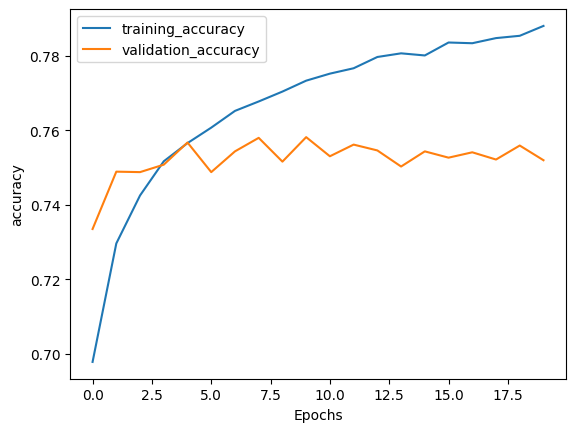

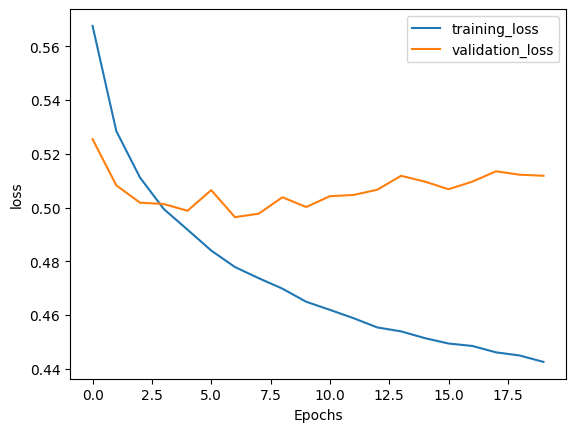

In [27]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([f'training_{metric}', f'validation_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
# Test the slope of your val_loss curve
epochs = [*range(20)]
val_loss = history.history['val_loss']
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is 0.00028
